<img src="https://i.imgur.com/Y6EMKKg.jpg" style="float: left; margin: 15px;" width="75">

## European Soccer Match Predictive Modeling

Joseph Darby

---

# Executive Summary:

The primary goal of this capstone project is to **accurately predict the outcomes of individual European football matches** with the provided database. The baseline accuracy rate for model comparison is 46%. This percentage represents the rate at which the home-team wins a given match. 

The database has been provided by Kaggle and is quite robust. Although, many of the tables do not share common keys and require careful attention when merging to fully integrate useful information. Overall, the data consists of results from over 25,000 matches and game events across 11 European countries from 2008-2016. Included are the player and team skill rankings scraped from the popular video game, EA Sport's FIFA. Finally, the database contains betting odds from 10 European bet brokers.


### Problem Statement:
**Using the EU Soccer Database provided, can we build a multi-classification model that predicts the outcome of a given match with better accuracy than the majority class distribution percentage of 46%?**

> **Stretch Goal:** Beat the book-makers average accuracy rate of 53%. 

<a id='index'></a>
### Technical Report Layout:
Step by step process from start to finish beginning with data cleaning & exploration process and ending with model evaluation:

1) [Import Required Libraries & Modules](#required_libraries)

2) [Database Structure](#database_structure)

3) [Data Consolidation](#data_consolidation) 

4) [Data Cleaning](#data_cleaning)

5) [Data Exploration](#data_exploration)

6) [Logistic Multi-Class Regression Model](#logistic_model)

7) [Random Forest Classification Model](#random_forest_model)


---
<a id='required_libraries'></a>
# 1) Import Required Libraries

[back to top](#index)

The following libraries and settings are required to follow along and run the project from start to finish:

In [2]:
#Libraries
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.tree import DecisionTreeClassifier

# Settings
pd.options.display.max_columns = 200
%matplotlib inline

---
<a id= 'database_structure'></a>
# 2) Database Structure

[back to top](#index)

### Exploring Database Structure:

In [3]:
# create the connection to the database file
db = "../01_Data_Cleaning/datasets_database/database.sqlite"
connection = sql.connect(db)

The database is formatted as a sqlite file. I used sqlite3 statements to access the tables and data within. Also, I created the following function to connect to the database file and quickly create a Pandas dataframe based on the table name input by the user. 

#### Function for Dataframe Creation:

In [4]:
def create_table_df(table):
    db = "../01_Data_Cleaning/datasets_database/database.sqlite"
    connection = sql.connect(db)

    query = '''SELECT * FROM {}'''.format(table)
    df = pd.read_sql_query(query, connection)
    
    return df

Below is an example of how the function returns a dataframe based on the user input. The **"Match" table** is the largest table in which all data from other tables is merged. It has 25979 rows and 115 columns with a substantial amount of null values throughout the dataframe. Many of these null values are related to missing betting odds or the players' field coordinate positions.

#### Match Table
- 25979 rows and 115 columns
- Substantial amount of null values throughout the dataframe. 
- Many null values are related to betting odds or the players' field coordinate positions.

In [5]:
match_df = create_table_df("Match")
match_df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


#### There are 7 tables in the Soccer Database:

**1) Country:** Consists of a unique ID series, and a "Country" series, which refers to the country in which a league resides. 

**2) League:** Refers to the specific leagues in which matches can be played. Most countries in Europe will have their own domestic league. This table contains a "name" series referring to league names, a unique id series per league, and the country id from the "Country" table.

**3) Match:** The "Match" table contains basic categorical information on each match collected in the database, such as that date the game was played, the teams in the competition, and home or away goals. In addition to these event-based statistics, the table contains the odds that betting bookkeepers assigned to the outcomes of the match, which include home-team win, away-team-win, or draw.

**4) Player:** This table contains basics player characteristics for the players gathered into the table. Such characteristics include the player's name, height, and weight. In addition to these series of data, the table contains a key ID series that connects each player to his "Player_Attributes" table data. 

**5) Player_Attributes:** All players in the "Player" table have a corresponding set of attributes in regard to his skill-level, style of play, and competitive mind-set as defined in the popular EA Sports video game, FIFA. The creator of the database scraped these attributes from sofifa.com for each player if they were in the game.

**6) Team:** Contains categorical team characteristics, like team name, along with unique ID's that link the team to is corresponding values in the "Team_Attributes" table.

**7) Team_Attributes:** Similar to the "Player_Attributes" table, the "Team_Attributes" table provides many categorical and numeric data points in relation to a team's style of play, competitive mindset, and other characteristics that describe the team as a whole.

---
<a id= 'data_consolidation'></a>
# 3) Data Consolidation:

[back to top](#index)

#### Merge Strategy
- Initially, I used SQLite statements to merge as much of the data in other tables with "Match" based on common keys. 
- However, I experienced technical difficulties with my machine as I attempted to merge the "Team_Attributes" and "Player_Attributes" tables.
- I made the decision to use CSV files with Pandas to combine the "Match," "Player_Attributes" and "Team_Attributes" tables.



#### "Match" Merged Table to CSV:
25979 rows x 118 columns

In [6]:
query = '''SELECT m.*, c.name AS country, l.name AS league_name, th.team_long_name as home_team,
ta.team_long_name as away_team
FROM Match as m
INNER JOIN Country AS c ON c."id" = m."country_id"
INNER JOIN League AS l ON l."id" = m."league_id"
INNER JOIN Team as th ON th."team_api_id" = m."home_team_api_id"
INNER JOIN Team as ta ON ta."team_api_id" = m."away_team_api_id"'''
model_df = pd.read_sql_query(query, connection)

# Create columns for month and year corresponding to Team_Attributes
model_df['year_month'] = model_df['date'].map(lambda x: pd.to_datetime(str(x)[0:7]))
model_df.drop(columns=['id', 'date'], inplace=True)

model_df.to_csv("../01_Data_Cleaning/datasets_database/combined_tables.csv", index=False)
model_df.head()

,country_id,league_id,season,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,country,league_name,home_team,away_team,year_month
0,1,1,2008/2009,1,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20,Belgium,Belgium Jupiler League,KRC Genk,Beerschot AC,2008-08-01
1,1,1,2008/2009,1,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60,Belgium,Belgium Jupiler League,SV Zulte-Waregem,Sporting Lokeren,2008-08-01
2,1,1,2008/2009,1,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75,Belgium,Belgium Jupiler League,KSV Cercle Brugge,RSC Anderlecht,2008-08-01
3,1,1,2008/2009,1,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50,Belgium,Belgium Jupiler League,KAA Gent,RAEC Mons,2008-08-01
4,1,1,2008/2009,1,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40

#### "Team_Attributes" Table to CSV:
1458 rows × 24 columns

In [39]:
team_attr_df = create_table_df("Team_Attributes")

# Create columns for month and year corresponding to Team_Attributes
team_attr_df['year_month'] = team_attr_df['date'].map(lambda x: pd.to_datetime(str(x)[0:7]))
team_attr_df.drop(columns=['id','date'], inplace=True)

team_attr_df.to_csv("../01_Data_Cleaning/datasets_database/team_attributes.csv", index=False)
team_attr_df.head()

,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,year_month
0,434,9930,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,65,Normal,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover,2010-02-01
1,434,9930,52,Balanced,48.0,Normal,56,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover,2014-09-01
2,434,9930,47,Balanced,41.0,Normal,54,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover,2015-09-01
3,77,8485,70,Fast,NaN,Little,70,Long,Organised,70,Risky,70,Lots,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover,2010-02-01
4,77,8485,47,Balanced,NaN,Little,52,Mixed,Organised,53,Normal,48,Normal,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover,2011-02-01


I created the following code to find and remove rows where there are multiple listings for one team in the same year and month.

In [9]:
api_id_set = set(team_attr_df['team_api_id'].values)

# Create a list of team_id's and all years on record
all_team_years = []
for team_id in api_id_set:
    team_years = team_attr_df[team_attr_df.loc[:, 'team_api_id'] == team_id]['year_month']
    for record in team_years:
        all_team_years.append(f'{team_id}, {record}')

# Create a set indicating team and duplicated year
all_duplicates = []
for each_listing in all_team_years:
    if all_team_years.count(each_listing) > 1:
        all_duplicates.append(each_listing)
    else:
        continue
all_duplicates = list(set(all_duplicates))

# Keep one row but remove the other duplicated year rows per team in the set
for each in all_duplicates:
    ix_drop = team_attr_df[(team_attr_df['team_api_id'] == int(each[0:4])) & (team_attr_df['year_month'] == str(each[6:]))].index[1:]
    team_attr_df.drop(ix_drop, inplace = True)

#### "Player_Attributes" & "Player"  Merged Table to CSV:
The Player table contains data the could be useful to analysis and modelling, such as player names, heights, and weights. I used SQLite to combine this data with that of the Player_Attributes table before saving to CSV.

183978 rows x 47 columns

In [10]:
query = '''SELECT p.*, pa.* 
FROM Player AS p
INNER JOIN Player_Attributes AS pa ON p."player_api_id" = pa."player_api_id"'''
player_join = pd.read_sql_query(query, connection)

# Create columns for month and year corresponding to Team_Attributes
player_join['year_month'] = player_join['date'].map(lambda x: pd.to_datetime(str(x)[0:7]))
player_join.drop(columns=['id', 'date'], inplace=True)

player_join.to_csv("../01_Data_Cleaning/datasets_database/player_attributes.csv", index=False)
player_join.head()

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,player_fifa_api_id,player_api_id,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,year_month
0,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,218353,505942,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,2016-02-01
1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,218353,505942,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,2015-11-01
2,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,218353,505942,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0,2015-09-01
3,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,218353,505942,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,2015-03-01
4,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,218353,505942,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,2007-02-01


---
<a id= 'data_cleaning'></a>
# 4) Data Cleaning:

[back to top](#index)

#### Function to Create a Column with the Match Result:

The ultimate goal of our model is to predict a Home Win, Draw, or Away Win. While the Match table provides home and away team goal counts per match, it does not provide a series related to the game outcome. I created a function to calculate the result of each match and assign a categorical value to it. 
- **W**:   Home-team win
- **D**:   Draw
- **L**:   Home-team loss (Away-team win)

In [11]:
# Create the function
def get_match_result(df):
    
    result_list = []
    
    for i in range(df.shape[0]):
        home_score = df['home_team_goal'].iloc[i]
        away_score = df['away_team_goal'].iloc[i]
        if home_score > away_score:
            result_list.append("W")
        elif home_score < away_score:
            result_list.append("L")
        else:
            result_list.append("D")
    df['match_result'] = result_list
    
    return "Success!"

### Cleaning the "Match" Dataframe:

In [41]:
# Dataframe of the "Match", "Team", "League", and "Country" tables joined together
combined_df = pd.read_csv("../01_Data_Cleaning/datasets_database/combined_tables.csv")

# Add target vector columns that of the results of each match (Home-Win = 'W', Draw = "D", Away-Win = "L")
get_match_result(combined_df)

'Success!'

In [42]:
# Make a list of the features we are interested in modeling & exploring
a_parsed_col_list = ['country','league_name', 'home_team', 'away_team', 'season', 'year_month', 'home_team_goal', 
                   'away_team_goal','match_result', 'match_api_id', 'stage', 'home_team_api_id', 'away_team_api_id', 
                   'B365A', 'B365D', 'B365H', 'BWA', 'BWD', 'BWH', 'IWA', 'IWD', 'IWH', 'away_player_1', 'home_player_1',
                   'away_player_2', 'home_player_2','away_player_3', 'home_player_3','away_player_4', 'home_player_4',
                   'away_player_5', 'home_player_5','away_player_6', 'home_player_6','away_player_7', 'home_player_7',
                   'away_player_8', 'home_player_8','away_player_9', 'home_player_9', 'away_player_10', 'home_player_10',
                   'away_player_11', 'home_player_11']


# Create Dataframe of columns we are interested in & drop null observations
parsed_df = combined_df[a_parsed_col_list].dropna()

In [43]:
# The season year needs to be one year instead of a combined string in order to join on team and player attributes
parsed_df['year'] = parsed_df['season'].map(lambda x: int(x[5:]))

replace_dict = {2009: 2010, 2010: 2010, 2011: 2011, 2012: 2012, 2013: 2013, 2014: 2014, 2015: 2015, 2016: 2015}

parsed_df['year'] = parsed_df['year'].map(replace_dict)

parsed_df.drop(columns='season', inplace=True)

In [44]:
# Home & Away_Player data types need to match that of the Player Attributes table
col_dict = {}
col_list = ['year', 'away_player_1', 'home_player_1','away_player_2', 'home_player_2','away_player_3', 
             'home_player_3','away_player_4', 'home_player_4','away_player_5', 'home_player_5', 'away_player_6', 
             'home_player_6','away_player_7', 'home_player_7','away_player_8', 'home_player_8','away_player_9', 
             'home_player_9', 'away_player_10', 'home_player_10','away_player_11', 'home_player_11']

for each in col_list:
    col_dict[each] = 'int64'
    
parsed_df = parsed_df.astype(col_dict)
parsed_df.reset_index(drop = True, inplace = True)

In [45]:
# Drop 'season' series and re-configure series layout
b_parsed_col_list = ['country','league_name', 'home_team', 'away_team', 'year', 'year_month', 'home_team_goal', 
                   'away_team_goal','match_result', 'match_api_id', 'stage', 'home_team_api_id', 'away_team_api_id', 
                   'B365A', 'B365D', 'B365H', 'BWA', 'BWD', 'BWH', 'IWA', 'IWD', 'IWH', 'away_player_1', 'home_player_1',
                   'away_player_2', 'home_player_2','away_player_3', 'home_player_3','away_player_4', 'home_player_4',
                   'away_player_5', 'home_player_5','away_player_6', 'home_player_6','away_player_7', 'home_player_7',
                   'away_player_8', 'home_player_8','away_player_9', 'home_player_9', 'away_player_10', 'home_player_10',
                   'away_player_11', 'home_player_11']

# Create Dataframe of columns we are interested in & drop null observations
parsed_df = parsed_df[b_parsed_col_list]

In [46]:
parsed_df.shape

(19620, 44)

### Incorporate "Team_Attributes" Dataframe
The "Team_Attibutes" dataframe will need to be merged twice with the "Match" dataframe as we have a home and away team in each match. Two separate dataframes were created for each team through a function to improve work efficiency.   


### Created a Function:

- Imports Team Attributes
- Removes unneccssary columns
- Reorganizes column layout
- **Removes rows where there are multiple listings per team team by year**

In [47]:
def create_clean_df(path, prefix):
    # Team Attributes dataframe to merge & drop unnecessary columns
    df = pd.read_csv(path)
    df.drop(columns = ['buildUpPlayDribbling', 'team_fifa_api_id'], inplace = True)
    
    # Create 'date_year' column and drop 'date'
    df['year'] = df['year_month'].map(lambda x: int(x[:4]))
    
    # Change column order & reset index after sort
    team_col_order = ['home_team_api_id', 'home_year', 'home_year_month','home_buildUpPlaySpeed', 'home_buildUpPlaySpeedClass', 
                      'home_buildUpPlayDribblingClass','home_buildUpPlayPassing', 'home_buildUpPlayPassingClass',
                      'home_buildUpPlayPositioningClass','home_chanceCreationPassing', 'home_chanceCreationPassingClass',
                      'home_chanceCreationCrossing','home_chanceCreationCrossingClass', 'home_chanceCreationShooting',
                      'home_chanceCreationShootingClass','home_chanceCreationPositioningClass', 'home_defencePressure',
                      'home_defencePressureClass','home_defenceAggression', 'home_defenceAggressionClass',
                      'home_defenceTeamWidth','home_defenceTeamWidthClass', 'home_defenceDefenderLineClass']
    new_order = [each.replace('home_','') for each in team_col_order]
    df = df[new_order]
    df = df.sort_values(by= ['team_api_id', 'year'], ascending=[True, True]).reset_index(drop=True)
    
    # Remove rows where a team has multiple rows for the same year
    # Create a set of team_id's
    api_id_set = set(df['team_api_id'].values)

    # Create a list of team_id's and all years on record
    all_team_years = []
    for team_id in api_id_set:
        team_years = df[df.loc[:, 'team_api_id'] == team_id]['year']
        for record in team_years:
            all_team_years.append(f'{team_id}, {record}')

    # Create a set indicating team and duplicated year
    all_duplicates = []
    for each_listing in all_team_years:
        if all_team_years.count(each_listing) > 1:
            all_duplicates.append(each_listing)
        else:
            continue
    all_duplicates = list(set(all_duplicates))
    
    # Keep one row but remove the other duplicated year rows per team in the set
    for each in all_duplicates:
        indexes_to_drop = df[(df['team_api_id'] == int(each[0:4])) & (df['year'] == int(each[6:]))].index[1:]
        df.drop(indexes_to_drop, inplace = True)

    # add 'home_' or 'away_'
    df = df.add_prefix(prefix)    
    return df

#### Home Team Dataframe:

In [48]:
# Use custom function on Home Team data
home_team_df = create_clean_df('../01_Data_Cleaning/datasets_database/team_attributes.csv', 'home_')

print(home_team_df.shape)
home_team_df.head()

(1457, 23)


,home_team_api_id,home_year,home_year_month,home_buildUpPlaySpeed,home_buildUpPlaySpeedClass,home_buildUpPlayDribblingClass,home_buildUpPlayPassing,home_buildUpPlayPassingClass,home_buildUpPlayPositioningClass,home_chanceCreationPassing,home_chanceCreationPassingClass,home_chanceCreationCrossing,home_chanceCreationCrossingClass,home_chanceCreationShooting,home_chanceCreationShootingClass,home_chanceCreationPositioningClass,home_defencePressure,home_defencePressureClass,home_defenceAggression,home_defenceAggressionClass,home_defenceTeamWidth,home_defenceTeamWidthClass,home_defenceDefenderLineClass
0,1601,2010,2010-02-01,30,Slow,Little,40,Mixed,Organised,50,Normal,35,Normal,70,Lots,Organised,65,Medium,60,Press,50,Normal,Cover
1,1601,2011,2011-02-01,48,Balanced,Little,51,Mixed,Organised,68,Risky,67,Lots,51,Normal,Organised,46,Medium,48,Press,50,Normal,Cover
2,1601,2012,2012-02-01,53,Balanced,Little,55,Mixed,Organised,44,Normal,65,Normal,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
3,1601,2013,2013-09-01,53,Balanced,Little,55,Mixed,Organised,44,Normal,65,Normal,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
4,1601,2014,2014-09-01,53,Balanced,Normal,38,Mixed,Organised,66,Normal,65,Normal,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover


#### Away Team Dataframe:

In [49]:
# Use custom function on Home Team data
away_team_df = create_clean_df('../01_Data_Cleaning/datasets_database/team_attributes.csv', 'away_')

print(away_team_df.shape)
away_team_df.head()

(1457, 23)


,away_team_api_id,away_year,away_year_month,away_buildUpPlaySpeed,away_buildUpPlaySpeedClass,away_buildUpPlayDribblingClass,away_buildUpPlayPassing,away_buildUpPlayPassingClass,away_buildUpPlayPositioningClass,away_chanceCreationPassing,away_chanceCreationPassingClass,away_chanceCreationCrossing,away_chanceCreationCrossingClass,away_chanceCreationShooting,away_chanceCreationShootingClass,away_chanceCreationPositioningClass,away_defencePressure,away_defencePressureClass,away_defenceAggression,away_defenceAggressionClass,away_defenceTeamWidth,away_defenceTeamWidthClass,away_defenceDefenderLineClass
0,1601,2010,2010-02-01,30,Slow,Little,40,Mixed,Organised,50,Normal,35,Normal,70,Lots,Organised,65,Medium,60,Press,50,Normal,Cover
1,1601,2011,2011-02-01,48,Balanced,Little,51,Mixed,Organised,68,Risky,67,Lots,51,Normal,Organised,46,Medium,48,Press,50,Normal,Cover
2,1601,2012,2012-02-01,53,Balanced,Little,55,Mixed,Organised,44,Normal,65,Normal,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
3,1601,2013,2013-09-01,53,Balanced,Little,55,Mixed,Organised,44,Normal,65,Normal,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
4,1601,2014,2014-09-01,53,Balanced,Normal,38,Mixed,Organised,66,Normal,65,Normal,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover


#### Merge Home & Away team dataframes with cleaned "Match" dataframe:

In [50]:
parsed_df = pd.merge(parsed_df, home_team_df, left_on=['home_team_api_id', 'year'], right_on=['home_team_api_id', 'home_year'], how='left')
parsed_df = pd.merge(parsed_df, away_team_df, left_on=['away_team_api_id', 'year'], right_on=['away_team_api_id', 'away_year'], how='left')

In [51]:
parsed_df.head()

,country,league_name,home_team,away_team,year,year_month,home_team_goal,away_team_goal,match_result,match_api_id,stage,home_team_api_id,away_team_api_id,B365A,B365D,B365H,BWA,BWD,BWH,IWA,IWD,IWH,away_player_1,home_player_1,away_player_2,home_player_2,away_player_3,home_player_3,away_player_4,home_player_4,away_player_5,home_player_5,away_player_6,home_player_6,away_player_7,home_player_7,away_player_8,home_player_8,away_player_9,home_player_9,away_player_10,home_player_10,away_player_11,home_player_11,home_year,home_year_month,home_buildUpPlaySpeed,home_buildUpPlaySpeedClass,home_buildUpPlayDribblingClass,home_buildUpPlayPassing,home_buildUpPlayPassingClass,home_buildUpPlayPositioningClass,home_chanceCreationPassing,home_chanceCreationPassingClass,home_chanceCreationCrossing,home_chanceCreationCrossingClass,home_chanceCreationShooting,home_chanceCreationShootingClass,home_chanceCreationPositioningClass,home_defencePressure,home_defencePressureClass,home_defenceAggression,home_defenceAggressionClass,home_defenceTeamWidth,home_defenceTeamWidthClass,home_defenceDefenderLineClass,away_year,away_year_month,away_buildUpPlaySpeed,away_buildUpPlaySpeedClass,away_buildUpPlayDribblingClass,away_buildUpPlayPassing,away_buildUpPlayPassingClass,away_buildUpPlayPositioningClass,away_chanceCreationPassing,away_chanceCreationPassingClass,away_chanceCreationCrossing,away_chanceCreationCrossingClass,away_chanceCreationShooting,away_chanceCreationShootingClass,away_chanceCreationPositioningClass,away_defencePressure,away_defencePressureClass,away_defenceAggression,away_defenceAggressionClass,away_defenceTeamWidth,away_defenceTeamWidthClass,away_defenceDefenderLineClass
0,Belgium,Belgium Jupiler League,KV Mechelen,KRC Genk,2010,2009-02-01,2,1,W,493017,24,8203,9987,2.30,3.4,3.00,2.20,3.25,2.95,2.2,3.1,2.80,37937,38327,38293,67950,148313,67958,104411,67959,148314,37112,37202,36393,43158,148286,9307,67898,42153,164352,32690,38801,38782,26502,2010.0,2010-02-01,65.0,Balanced,Little,60.0,Mixed,Organised,50.0,Normal,40.0,Normal,50.0,Normal,Organised,60.0,Medium,70.0,Double,60.0,Normal,Cover,2010.0,2010-02-01,45.0,Balanced,Little,45.0,Mixed,Organised,50.0,Normal,35.0,Normal,60.0,Normal,Organised,70.0,High,65.0,Press,70.0,Wide,Cover
1,Belgium,Belgium Jupiler League,KSV Cercle Brugge,Club Brugge KV,2010,2009-03-01,1,3,L,493025,25,9984,8342,2.37,3.2,2.80,2.20,3.00,3.10,2.2,3.1,2.80,37990,36835,21812,37047,11736,37021,37858,37051,38366,104386,37983,32863,39578,37957,38336,37909,52280,38357,27423,37065,38440,78462,2010.0,2010-02-01,45.0,Balanced,Little,35.0,Mixed,Organised,70.0,Risky,45.0,Normal,55.0,Normal,Organised,65.0,Medium,60.0,Press,70.0,Wide,Cover,2010.0,2010-02-01,35.0,Balanced,Little,40.0,Mixed,Organised,45.0,Normal,50.0,Normal,45.0,Normal,Organised,60.0,Medium,70.0,Double,70.0,Wide,Cover
2,Belgium,Belgium Jupiler League,RSC Anderlecht,SV Zulte-Waregem,2010,2009-03-01,2,0,W,493027,25,8635,10000,8.00,4.5,1.40,9.00,4.00,1.35,7.0,4.0,1.35,37900,34480,37886,38388,37903,26458,37889,13423,94030,38389,37893,30949,37981,38393,131531,38253,130027,38383,38231,38778,131530,37069,2010.0,2010-02-01,50.0,Balanced,Little,35.0,Mixed,Organised,70.0,Risky,50.0,Normal,60.0,Normal,Organised,70.0,High,50.0,Press,70.0,Wide,Cover,2010.0,2010-02-01,65.0,Balanced,Little,60.0,Mixed,Organised,60.0,Normal,40.0,Normal,50.0,Normal,Organised,70.0,High,60.0,Press,70.0,Wide,Cover
3,Belgium,Belgium Jupiler League,KV Mechelen,RSC Anderlecht,2010,2009-03-01,2,1,W,493034,26,8203,8635,1.75,3.6,4.50,1.70,3.30,4.70,1.7,3.2,4.20,34480,38327,38388,67950,38389,67958,31316,38801,164694,67898,30949,37112,38378,67959,38383,148286,38393,164352,38253,33657,37069,26502,2010.0,2010-02-01,65.0,Balanced,Little,60.0,Mixed,Organised,50.0,Normal,40.0,Normal,50.0,Normal,Organised,60.0,Medium,70.0,Double,60.0,Normal,Cover,2010.0,2010-02-01,50.0,Balanced,Little,35.0,Mixed,Organised,70.0,Risky,50.0,Normal,60.0,Normal,Organised,70.0,High,50.0,Press,70.0,Wide,Cover
4,Belgium,Belgium Jupiler League,SV Zulte-Wa

### Incorporating "Player_Attributes" Data

In [52]:
# Import CSV
player_attr_df = pd.read_csv('../01_Data_Cleaning/datasets_database/player_attributes.csv')

# Create a dictionary to map player names
num_id = list(player_attr_df["player_api_id"].values)
player_name = list(player_attr_df['player_name'].values)
player_dict = dict(zip(num_id, player_name))

# Create a dictionary to map each player's average overall rating
avg_df = player_attr_df.groupby(by='player_api_id').mean()
overall_rate_dict = dict(avg_df.overall_rating)

# Create a list of the series to map over
player_series_list = ['away_player_1', 'home_player_1', 'away_player_2', 'home_player_2', 'away_player_3',
                      'home_player_3', 'away_player_4', 'home_player_4', 'away_player_5', 'home_player_5', 
                      'away_player_6', 'home_player_6', 'away_player_7', 'home_player_7', 'away_player_8', 
                      'home_player_8', 'away_player_9', 'home_player_9', 'away_player_10', 'home_player_10', 
                      'away_player_11', 'home_player_11']

# Create a for loop to map names and create overall rating columns
for each in player_series_list:
    parsed_df[each + '_rating'] = parsed_df[each].map(overall_rate_dict)
    parsed_df[each] = parsed_df[each].map(player_dict)

# Re-configure column layout and perge columns that are no longer needed
col = ['country', 'league_name', 'home_team', 'away_team', 'year', 'year_month', 'home_team_goal', 'away_team_goal', 
       'match_result', 'B365A', 'B365D', 'B365H', 'BWA', 'BWD', 'BWH', 'IWA', 'IWD', 'IWH', 'home_player_1', 
       'home_player_1_rating', 'home_player_2', 'home_player_2_rating','home_player_3', 'home_player_3_rating',
       'home_player_4', 'home_player_4_rating', 'home_player_5','home_player_5_rating', 'home_player_6', 
       'home_player_6_rating', 'home_player_7', 'home_player_7_rating', 'home_player_8', 'home_player_8_rating', 
       'home_player_9', 'home_player_9_rating', 'home_player_10', 'home_player_10_rating', 'home_player_11',
       'home_player_11_rating', 'away_player_1', 'away_player_1_rating','away_player_2', 'away_player_2_rating', 
       'away_player_3', 'away_player_3_rating', 'away_player_4', 'away_player_4_rating', 'away_player_5',
       'away_player_5_rating', 'away_player_6', 'away_player_6_rating','away_player_7', 'away_player_7_rating',
       'away_player_8', 'away_player_8_rating', 'away_player_9', 
       'away_player_9_rating', 'away_player_10', 'away_player_10_rating', 'away_player_11', 'away_player_11_rating',
       'home_buildUpPlaySpeed', 'home_buildUpPlaySpeedClass', 'home_buildUpPlayDribblingClass',
       'home_buildUpPlayPassing', 'home_buildUpPlayPassingClass', 'home_buildUpPlayPositioningClass',
       'home_chanceCreationPassing', 'home_chanceCreationPassingClass', 'home_chanceCreationCrossing',
       'home_chanceCreationCrossingClass', 'home_chanceCreationShooting', 'home_chanceCreationShootingClass',
       'home_chanceCreationPositioningClass', 'home_defencePressure', 'home_defencePressureClass', 'home_defenceAggression',
       'home_defenceAggressionClass', 'home_defenceTeamWidth', 'home_defenceTeamWidthClass', 'home_defenceDefenderLineClass',
       'away_buildUpPlaySpeed', 'away_buildUpPlaySpeedClass', 'away_buildUpPlayDribblingClass', 
       'away_buildUpPlayPassing', 'away_buildUpPlayPassingClass', 'away_buildUpPlayPositioningClass',
       'away_chanceCreationPassing', 'away_chanceCreationPassingClass', 'away_chanceCreationCrossing',
       'away_chanceCreationCrossingClass', 'away_chanceCreationShooting', 'away_chanceCreationShootingClass', 
       'away_chanceCreationPositioningClass', 'away_defencePressure', 'away_defencePressureClass', 'away_defenceAggression',
       'away_defenceAggressionClass', 'away_defenceTeamWidth', 'away_defenceTeamWidthClass', 'away_defenceDefenderLineClass']

# Assign new layout to a new dataframe and save dataframe to a csv for EDA and modeling
parsed_df = parsed_df[col]
parsed_df.to_csv('../01_Data_Cleaning/datasets_database/6.11_combined_df.csv')

In [53]:
parsed_df.shape

(19620, 102)

---
<a id= 'data_exploration'></a>
# 5) Data Exploration & Visualizations

[back to top](#index)

### Create Dataframe with most correlated data:

In [54]:
# Convert 'result' series to numeric
parsed_df['result'] = parsed_df['match_result'].map({'L' : 0, 'D': 1, 'W': 2})
parsed_df = parsed_df.drop(columns=['match_result'])

# Get list of all columns
col_names = list(parsed_df.columns)
col_names

# Manually remove least correlated features:
columns_list= ['country', 'league_name', 'home_team', 'away_team', 'home_team_goal', 'away_team_goal', 'B365A', 'B365D',
               'B365H', 'BWA', 'BWD', 'BWH', 'IWA', 'IWD', 'IWH', 'home_player_1', 'home_player_1_rating', 'home_player_2', 'home_player_2_rating', 'home_player_3',
               'home_player_3_rating', 'home_player_4', 'home_player_4_rating', 'home_player_5', 'home_player_5_rating',
               'home_player_6', 'home_player_6_rating', 'home_player_7', 'home_player_7_rating', 'home_player_8',
               'home_player_8_rating', 'home_player_9', 'home_player_9_rating', 'home_player_10', 'home_player_10_rating',
               'home_player_11', 'home_player_11_rating', 'away_player_1', 'away_player_1_rating', 'away_player_2',
               'away_player_2_rating', 'away_player_3', 'away_player_3_rating', 'away_player_4', 'away_player_4_rating',
               'away_player_5', 'away_player_5_rating', 'away_player_6', 'away_player_6_rating', 'away_player_7',
               'away_player_7_rating', 'away_player_8', 'away_player_8_rating', 'away_player_9', 'away_player_9_rating',
               'away_player_10', 'away_player_10_rating', 'away_player_11', 'away_player_11_rating', 'result']

# Create dataframe:
no_team_data_df = parsed_df[columns_list]

#### Dataframe Correlation Heatmap

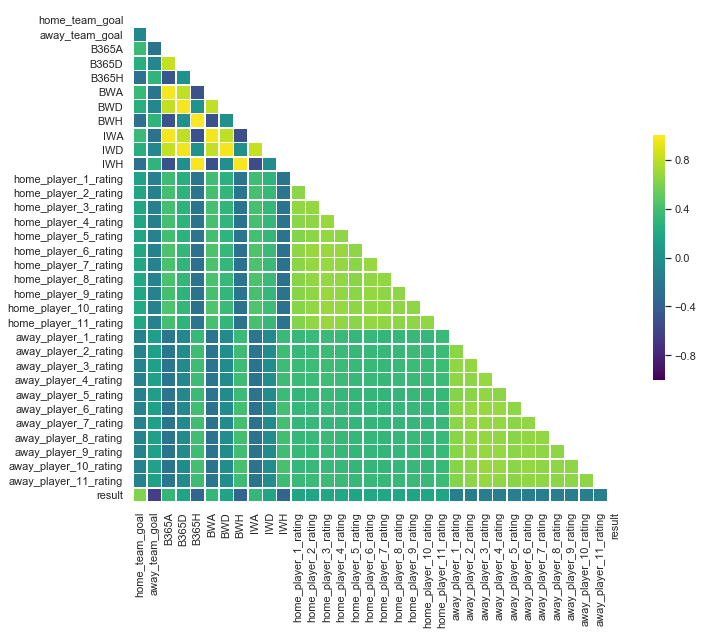

In [25]:
sns.set(style="white")

# Compute the correlation matrix
corr = no_team_data_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='viridis', vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

# Referenced Seaborn documentation website for code:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html?highlight=correlation%20plots

#### Target Vector ('result') Correlation Heatmap

Text(0.5, 1.0, 'Most Correlated Features w/ Match Result')

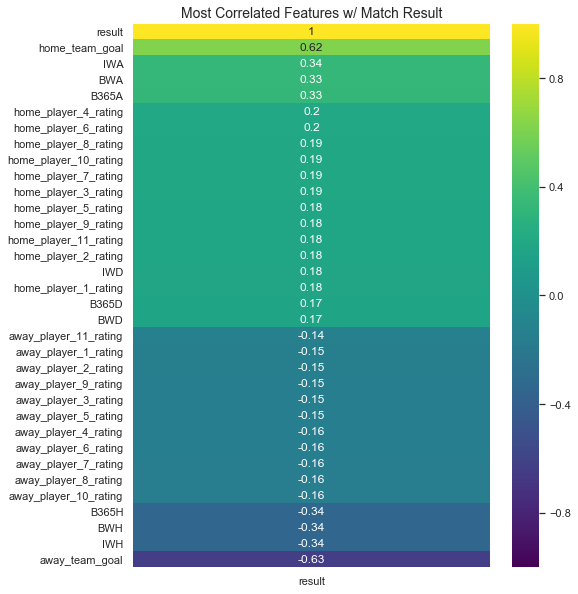

In [27]:
plt.figure(figsize=(8, 10))
sns.heatmap(no_team_data_df.corr()[['result']].sort_values(by='result', ascending = False), cmap = "viridis", annot=True, vmin= -1, vmax = 1)
plt.title('Most Correlated Features w/ Match Result', fontsize=14)

#### Match Results Frequency (from Home Team perspective)

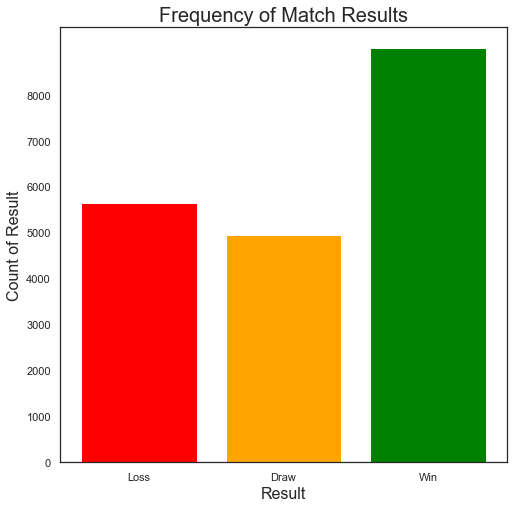

In [29]:
home_results = [5655, 4948, 9017]
plt.figure(figsize=(8,8))
plt.bar(['Loss','Draw','Win'], height=home_results, align='center', color= ['red', 'orange', 'green'])
plt.title('Frequency of Match Results', fontsize= 20)
plt.ylabel('Count of Result', fontsize= 16)
plt.yticks(np.arange(0,9000,1000))
plt.xlabel('Result', fontsize=16);

#### Home Team Goals & Match Result Correlation Scatterplot

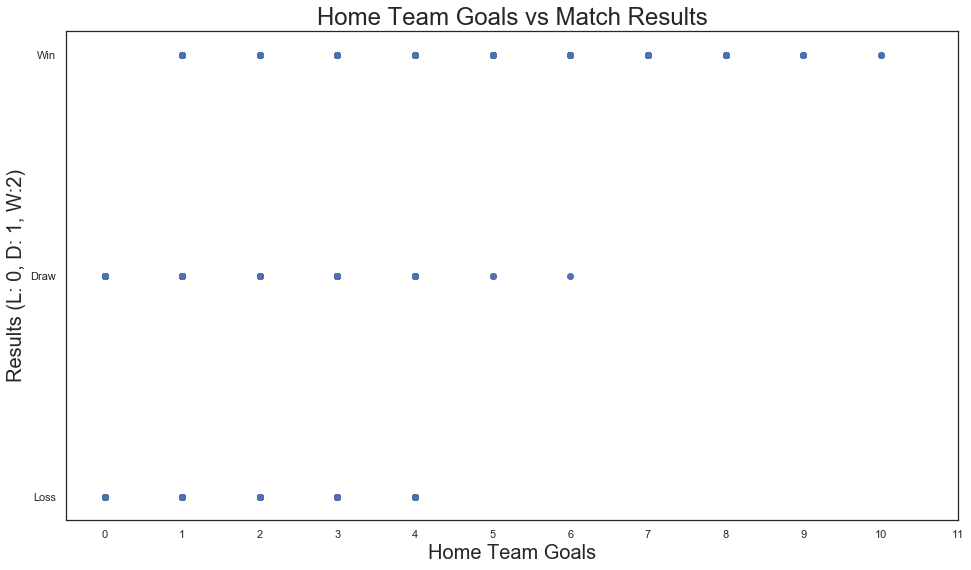

In [28]:
# Establish the size of the figure.
plt.figure(figsize=(16, 9))

# Create scatter plot of high prices versus volume.
plt.scatter(parsed_df['home_team_goal'],   # X axis
            parsed_df['result']) # Y axis

plt.title('Home Team Goals vs Match Results', fontsize= 24)
plt.ylabel("Results (L: 0, D: 1, W:2)", fontsize = 20)
plt.xlabel("Home Team Goals", fontsize = 20)
plt.xticks(np.arange(0,12, step = 1))
plt.yticks(np.arange(0,2.5, step = 1), labels=['Loss', 'Draw', 'Win']);

## Team-Specific Performance Dataframe

I am curious to see home team performance as it relates to match results for each team. The individual team is the index with columns that consist of win, loss and draw counts. It will be essential to calculate the win, loss, and draw percentages as teams do not share the same number of games where data has been collected. This is due to a couple of reasons. The data only consists of matches from each country's top professional league and does not include inter-country tournaments, such as the UEFA Champion's League. In addition, these country-specific leagues generally share common characteristics:

- Each country has a hierarchy of professional league division. 
    - In England, the English Premiership League (EPL) is the top and first division in the professional hierarchy, followed by the Championship Division (2nd division), then League One (3rd division), then League Two (4th division), and so on.  
- At the end of each season, a certain number of bottom-ranked teams in each country's top professional league will be relegated to the professional division below. 
- In the other direction, the same number of top finishing teams in the 2nd Division, England's Championship Division, will be promoted to the top professional league, England's EPL.

**The number of games with data gathered for each team can differ due to the fluctuation in the teams competing in each country's first division from season to season. Calculating performance as a percentage will better illustrate a team's performance in the top division, as opposed to simply counting match results.**

### Creating the dataframe:

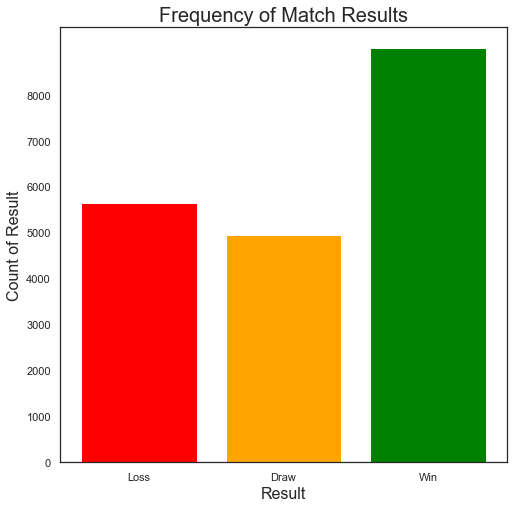

In [131]:
home_results = [5655, 4948, 9017]
plt.figure(figsize=(8,8))
plt.bar(['Loss','Draw','Win'], height=home_results, align='center', color= ['red', 'orange', 'green'])
plt.title('Frequency of Match Results', fontsize= 20)
plt.ylabel('Count of Result', fontsize= 16)
plt.yticks(np.arange(0,9000,1000))
plt.xlabel('Result', fontsize=16);

In [30]:
parsed_df['win'] = parsed_df['result'].map({0:0, 1:0, 2:1})
parsed_df['draw'] = parsed_df['result'].map({0:0, 1:1, 2:0})
parsed_df['loss'] = parsed_df['result'].map({0:1, 1:0, 2:0})

visualization_cols = ['country', 'league_name', 'home_team', 'away_team', 'year', 'year_month','home_team_goal', 'away_team_goal',
                      'result', 'win','draw','loss']

visualization_df = parsed_df[visualization_cols]

team_results_df = visualization_df.pivot_table(index='home_team', values=['win','draw','loss'], aggfunc='sum')
team_results_df = team_results_df[['win','loss','draw']]

team_results_df['win_perc'] = team_results_df.index.map(lambda x: team_results_df.loc[x][0] / team_results_df.loc[x].sum())
team_results_df['loss_perc'] = team_results_df.index.map(lambda x: team_results_df.loc[x][1] / team_results_df.loc[x].sum())
team_results_df['draw_perc'] = team_results_df.index.map(lambda x: team_results_df.loc[x][2] / team_results_df.loc[x].sum())

#### Teams with highest home win percentages:

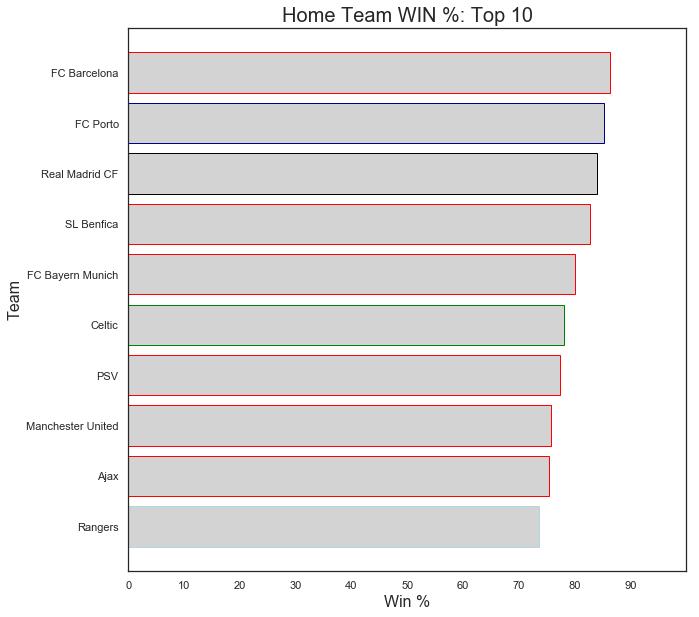

In [31]:
team_win_top_ten = team_results_df.sort_values(by = 'win_perc', ascending = False)[:10]

primary_colors = 'lightgray'
secondary_colors = ['red', 'darkblue', 'black', 'red', 'red', 'green', 'red', 'red', 'red', 'lightblue']

plt.figure(figsize=(10,10))
plt.barh(team_win_top_ten.index, width= team_win_top_ten['win_perc'], color= primary_colors, edgecolor= secondary_colors)
plt.gca().invert_yaxis()
plt.title('Home Team WIN %: Top 10', fontsize=20)
plt.xlim(right=1)
plt.xticks(ticks=np.arange(0,1,0.1), labels=np.arange(0,100,10))
plt.xlabel('Win %', fontsize=16)
plt.ylabel('Team', fontsize = 16);

#### Worst performing home teams (Losing Percentage):

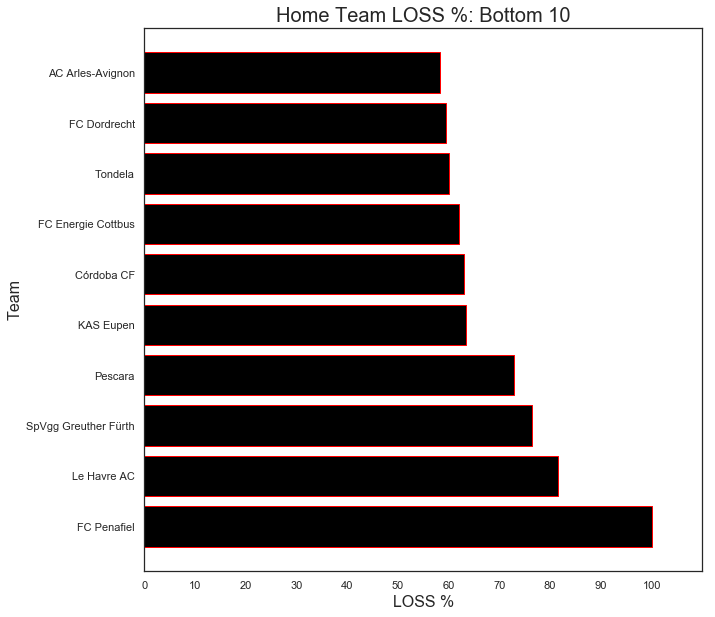

In [32]:
worst_team_win_df = team_results_df.sort_values(by = 'loss_perc', ascending = False)[:10].sort_values(by='loss_perc', ascending = True)

primary_colors = 'black'

plt.figure(figsize=(10,10))
plt.barh(worst_team_win_df.index, width= worst_team_win_df['loss_perc'], color= primary_colors, edgecolor= 'red')
plt.gca().invert_yaxis()
plt.title('Home Team LOSS %: Bottom 10', fontsize=20)
plt.xlim(right=1)
plt.xticks(ticks=np.arange(0,1.2,0.1), labels=np.arange(0,110,10))
plt.xlabel('LOSS %', fontsize=16)
plt.ylabel('Team', fontsize = 16);

Many of the teams in the list above have fewer than twenty games with twenty games. A team will play 38 games per league season, as each country's top league consists of 20 competing teams. Every team will play each other twice, once at home and once away. As a team cannot play itself, a team's season consists of 38 games. 

The reason these teams have fewer games with data is likely due to the data cleaning process. Some matches corresponding to these teams contained null fields and were removed. Also, this could be caused by a team entering their county's top division for the first time in the finaly year the data was collected and the collection process ended before the end of the season. However, I believe it is much more likely that match data was dropped due to null values being cleaned for the modeling process. 

---
<a id= 'logistic_model'></a>
# 6) Logistic Regression Model

[back to top](#index)

### Load & Clean Dataframe for Modeling:
The dataset that I will be working with in this notebook is my hand-selected features dataframe with all observations with null values removed. The amount of match observations is significantly higher than the comprehensive dataframe in the previous notebook. This data-set has 22,568 match observations compared to the 1762 in the previous data-set.

In [83]:
# Read in data.
df = pd.read_csv('../01_Data_Cleaning/datasets_database/6.11_combined_df.csv')
df['result'] = df['match_result'].map({'L' : 0, 'D': 1, 'W': 2})

# Drop player names as adding dummies to these values would greatly increase the dimensions of the dataframe
no_player_names = ['country', 'home_team', 'away_team', 'year', 'home_team_goal', 'away_team_goal',
                   'B365A', 'B365D', 'B365H', 'BWA', 'BWD', 'BWH', 'IWA', 'IWD', 'IWH', 
                   'home_player_1_rating', 'home_player_2_rating', 'home_player_3_rating',
                   'home_player_4_rating', 'home_player_5_rating', 'home_player_6_rating', 'home_player_7_rating',
                   'home_player_8_rating', 'home_player_9_rating', 'home_player_10_rating', 'home_player_11_rating',
                   'away_player_1_rating', 'away_player_2_rating', 'away_player_3_rating', 'away_player_4_rating',
                   'away_player_5_rating', 'away_player_6_rating', 'away_player_7_rating', 'away_player_8_rating',
                   'away_player_9_rating', 'away_player_10_rating', 'away_player_11_rating', 'home_buildUpPlaySpeed',
                   'home_buildUpPlaySpeedClass', 'home_buildUpPlayDribblingClass', 'home_buildUpPlayPassing',
                   'home_buildUpPlayPassingClass', 'home_buildUpPlayPositioningClass', 'home_chanceCreationPassing',
                   'home_chanceCreationPassingClass', 'home_chanceCreationCrossing', 'home_chanceCreationCrossingClass',
                   'home_chanceCreationShooting', 'home_chanceCreationShootingClass', 'home_chanceCreationPositioningClass',
                   'home_defencePressure', 'home_defencePressureClass', 'home_defenceAggression', 'home_defenceAggressionClass',
                   'home_defenceTeamWidth', 'home_defenceTeamWidthClass', 'home_defenceDefenderLineClass', 
                   'away_buildUpPlaySpeed', 'away_buildUpPlaySpeedClass', 'away_buildUpPlayDribblingClass', 'away_buildUpPlayPassing',
                   'away_buildUpPlayPassingClass', 'away_buildUpPlayPositioningClass', 'away_chanceCreationPassing',
                   'away_chanceCreationPassingClass', 'away_chanceCreationCrossing', 'away_chanceCreationCrossingClass',
                   'away_chanceCreationShooting', 'away_chanceCreationShootingClass', 'away_chanceCreationPositioningClass',
                   'away_defencePressure', 'away_defencePressureClass', 'away_defenceAggression', 'away_defenceAggressionClass',
                   'away_defenceTeamWidth', 'away_defenceTeamWidthClass', 'away_defenceDefenderLineClass', 'result']

#drop nulls if there are any remaining & get dummies for 'object' type features
df = df[no_player_names].dropna()
df = pd.get_dummies(df, drop_first=True)

print(f'Shape: {df.shape}')

# Check the distribution of our 'result'
df['result'].value_counts(normalize=True)

Shape: (19373, 599)


2    0.459557
0    0.288081
1    0.252362
Name: result, dtype: float64

##### Majority Class Baseline = 45.91%

### Logistic Regression Multiclass Classification Model:

I dropped home and away goals as they were used to define the target vector, "result." Possible outcomes are "Win", "Draw", or "Loss". Thus, we have three classes that we are trying to predict from our features.

In [84]:
# Create target matrix and training sets
results = df[['result']]
df = df.drop(columns=['result', 'home_team_goal', 'away_team_goal'])

# Set up X and y.
X = df
y = results['result']

# train/test split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    stratify=y,
                                                    random_state = 42)

# Instantiate Logistic Regression model
lr = LogisticRegression(solver='lbfgs', multi_class = 'multinomial', max_iter = 19400)

#### Evaluate Cross-Validation Score before Fit

In [85]:
print('Train CV Score:', cross_val_score(lr, X_train, y_train, cv=5).mean())

Train CV Score: 0.5133844293303274


In [86]:
# Fit model.
lr.fit(X_train, y_train)

# Generate predictions and compare scores
preds = lr.predict(X_test)
print("Logistic Acc. Score:", lr.score(X_test, y_test))

Logistic Acc. Score: 0.5220233998623538


**\* Logistic Regression model outperformed the majority class distribution percentage. So, I will say the baseline is the logistic regression accuracy score of 52.20%**

#### New Baseline: 52.20%

### Plotting the Logistic Probability Distributions of Each Class:

First, I looked at the true outome of each match, and compare that value with the probability that the model predicted. Then I looked at the model's predicted outcome and that associated probability.

In [87]:
# Referenced stack overflow for code below
# https://stackoverflow.com/questions/5469286/how-to-get-the-index-of-a-maximum-element-in-a-numpy-array-along-one-axis

# What value the model predicts
model_preds = [i.argmax(axis=0) for i in lr.predict_proba(X_test)]

# Model predicted value probability
model_proba = [i.max() for i in lr.predict_proba(X_test)]

# Model predicted probability of the true value
prob_list = []
for index, probability in enumerate(lr.predict_proba(X_test)):
    prob_list.append(probability[y_test.values[index]])
pred_proba = prob_list

# Create the predicted probabilities dataframe
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba,
                        'model_preds': model_preds,
                        'model_proba': model_proba
                        })
pred_df.head()

,true_values,pred_probs,model_preds,model_proba
7862,0,0.234480,2,0.566394
5263,2,0.535197,2,0.535197
17571,2,0.911125,2,0.911125
890,0,0.330246,1,0.365787
12779,2,0.635709,2,0.635709


### Visualizing the Probability Distribution of Each Class:

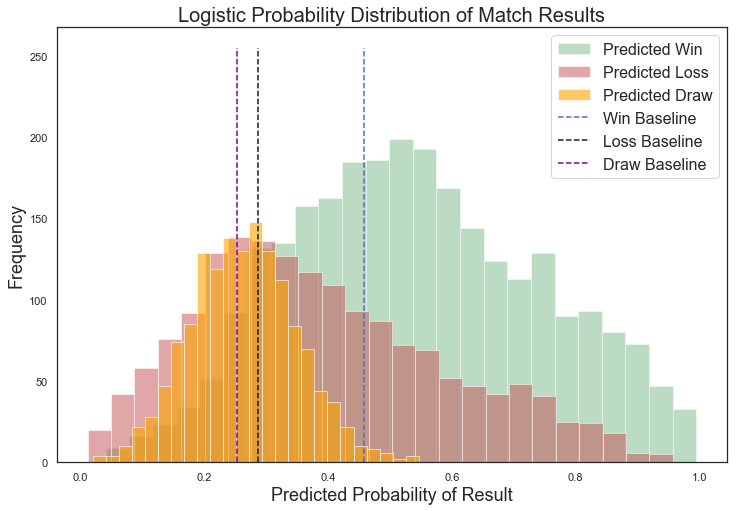

In [88]:
# Create figure.
plt.figure(figsize = (12,8))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 2]['pred_probs'],
         bins=25,
         color='g',
         alpha = 0.4,
         label='Predicted Win')

plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='r',
         alpha = 0.5,
         label='Predicted Loss')

plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Predicted Draw')

# Add vertical line at baseline distribution percentage for each class from dataset.
plt.vlines(x=0.459057,
           ymin = 0,
           ymax = 255,
           color='b',
           linestyle = '--',
          label= 'Win Baseline')

plt.vlines(x=0.287841,
           ymin = 0,
           ymax = 255,
           color='k',
           linestyle = '--',
          label = 'Loss Baseline')

plt.vlines(x=0.253102,
           ymin = 0,
           ymax = 255,
           color='purple',
           linestyle = '--',
          label= 'Draw Baseline')

# Label axes.
plt.title('Logistic Probability Distribution of Match Results', fontsize=20)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability of Result', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

---
<a id= 'random_forest_model'></a>
# 7) Random Forest Classification

[back to top](#index)

A Decision Tree Classification model as well. However, the Random Forrest Classification model provided better results.

In [89]:
# Set up X and y.
X = df
y = results['result']

# train/test split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    stratify=y,
                                                    random_state = 42)

In [90]:
# Baseline Random Forest Model
rf = RandomForestClassifier(n_estimators= 25)
prefit_CV = cross_val_score(rf, X_train, y_train, cv=5).mean()

In [91]:
# Improved Random Forest Grid Search Model
rf = RandomForestClassifier(random_state= 42)
rf_params = {
    'n_estimators': [30, 40],
    'max_depth': [5, 6, 7, 8],
    'max_features': ['auto', 4, 5, 6,],
    'min_samples_split': [2, 3, 4, 5, 6]
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_) # Best cross val score
gs.best_params_    # Best parameter combination

0.5361698989750019


{'max_depth': 8,
 'max_features': 'auto',
 'min_samples_split': 5,
 'n_estimators': 30}

#### Evaluate Cross-Validation Score before Fit

In [93]:
# Compare to Baseline Random Forest Model Score
print(f'Pre-fit RF 5-fold CV-Score: {prefit_CV}')
print(f'RF Train Score = {gs.score(X_train, y_train)}')
print(f'RF Test Score = {gs.score(X_test, y_test)}')

Pre-fit RF 5-fold CV-Score: 0.5045342985685384
RF Train Score = 0.552319150505125
RF Test Score = 0.5304542326221611


Using Grid Search accross the Random Forest Hyperparameters produced the best results. This improved the base Random Forest accuracy score 3.00% from 50.05% to 53.05%.

#### Generate Predictions

In [94]:
# Generate predictions and compare scores
preds = gs.predict(X_test)
print("Random Forest Acc. Score:", gs.score(X_test, y_test))

Random Forest Acc. Score: 0.5304542326221611


### Plotting the Logistic Probability Distributions of Each Class

In [95]:
# Referenced stack overflow for code below
# https://stackoverflow.com/questions/5469286/how-to-get-the-index-of-a-maximum-element-in-a-numpy-array-along-one-axis

# What value the model predicts
model_preds = [i.argmax(axis=0) for i in gs.predict_proba(X_test)]

# Model predicted value probability
model_proba = [i.max() for i in gs.predict_proba(X_test)]

# Model predicted probability of the true value
prob_list = []
for index, probability in enumerate(gs.predict_proba(X_test)):
    prob_list.append(probability[y_test.values[index]])
pred_proba = prob_list

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba,
                        'model_preds': model_preds,
                        'model_proba': model_proba
                        })
pred_df.head()

,true_values,pred_probs,model_preds,model_proba
7862,0,0.257184,2,0.450023
5263,2,0.577433,2,0.577433
17571,2,0.812613,2,0.812613
890,0,0.377002,0,0.377002
12779,2,0.569287,2,0.569287


### Visualizing the Probability Distribution of Each Class

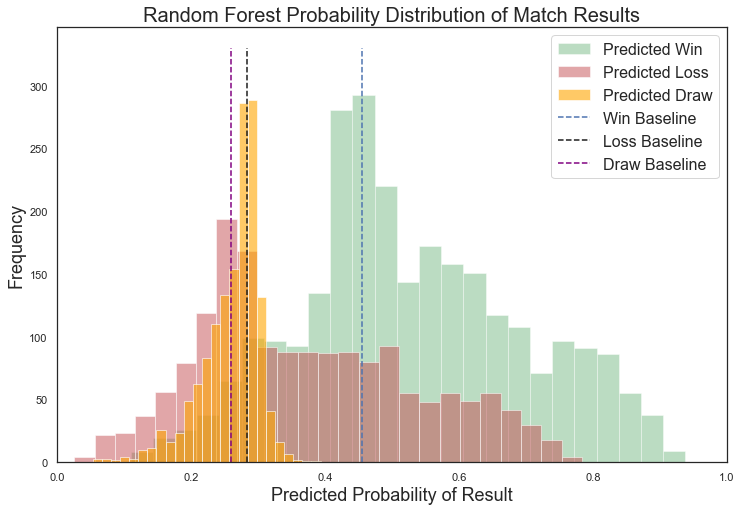

In [96]:
# Create figure.
plt.figure(figsize = (12,8))

# Create three histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 2]['pred_probs'],
         bins=25,
         color='g',
         alpha = 0.4,
         label='Predicted Win')

plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='r',
         alpha = 0.5,
         label='Predicted Loss')

plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Predicted Draw')

# Add vertical line at baseline distributions from dataset.
plt.vlines(x=0.455732,
           ymin = 0,
           ymax = 330,
           color='b',
           linestyle = '--',
          label= 'Win Baseline')

plt.vlines(x=0.2843,
           ymin = 0,
           ymax = 330,
           color='k',
           linestyle = '--',
          label = 'Loss Baseline')

plt.vlines(x=0.2599,
           ymin = 0,
           ymax = 330,
           color='purple',
           linestyle = '--',
          label= 'Draw Baseline')

# Label axes.
plt.title('Random Forest Probability Distribution of Match Results', fontsize=20)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability of Result', fontsize=18)

# Set X axis range
plt.xlim(0,1)

# Create legend.
plt.legend(fontsize=16);